<a href="https://colab.research.google.com/github/yankit247/land-use-land-cover/blob/main/lulc_py.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

"Land Use Classification with Machine Learning: A Comprehensive Approach using Support Vector Machines, Random Forests, and Decision Trees on Satellite Imagery"

Comprehensive land use classification using SVM, Random Forests, and Decision Trees on satellite imagery.
Workflow includes data preprocessing, feature extraction, model training, accuracy assessment, and GeoTIFF result export.
Adaptable to diverse regions, the code is a valuable resource for remote sensing and machine learning in natural resource management

In [ ]:
# run this only if you have not installed the requried packages
!pip install numpy
!pip install pandas
!pip install matplotlib
!pip install seaborn
!pip install sklearn
!pip install rasterio
!pip install geopandas
!pip install fiona

  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.6/20.6 MB 49.9 MB/s eta 0:00:00


# 1 - Feature Extraction

### Loading required libraries

In [ ]:
import rasterio as rio
from rasterio.plot import show
import geopandas as gpd
import fiona
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import sklearn
from sklearn.metrics import classification_report, accuracy_score

### Providing the path to the data

In [ ]:
# variables
# Note: labels should be always last column with name "labels"
# Note: Make sure input labels shapefile and input raster have same CRS, otherwise code will not run

# input files
raster_loc = 's2image.tif'
points_loc = 'samples.shp'
temp_point_loc = 'temp_y_points.shp'

# land cover names (for post visualization)
lulc_name = ['Water', 'Dense Veg', 'Veg', 'Impervious']

### Loading  data

### Visualizing the data

In [ ]:
src = rio.open(raster_loc)

blue = src.read(1, masked=True)
green = src.read(2, masked=True)
red = src.read(3, masked=True)
nir = src.read(4, masked=True)

def normalize(array):
    """Normalizes numpy arrays into scale 0.0 - 1.0"""
    array_min, array_max = array.min(), array.max()
    return ((array - array_min)/(array_max - array_min))

# Normalize the bands
redn = normalize(red)
greenn = normalize(green)
bluen = normalize(blue)
nirn = normalize(nir)

/usr/local/lib/python3.10/dist-packages/numpy/ma/core.py:1156: RuntimeWarning: overflow encountered in divide
  result = self.f(da, db, *args, **kwargs)


### RGB Visualize

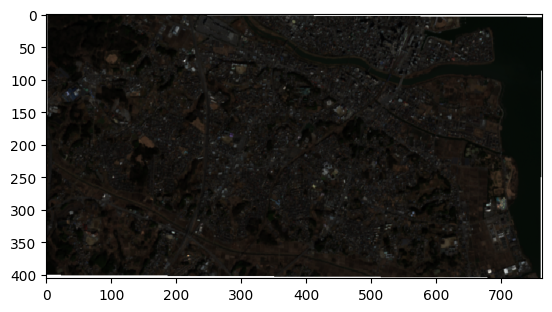

In [ ]:
rgb = np.dstack((redn, greenn, bluen))

plt.imshow(rgb)

### False Color Composite Visualize

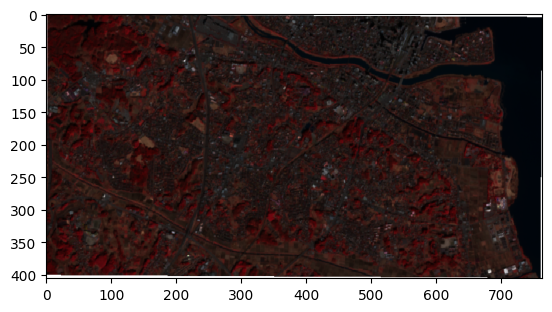

In [ ]:
nrg = np.dstack((nirn, redn,greenn))

plt.imshow(nrg)

### Visualizing each bands

Text(0.5, 1.0, 'Blue')

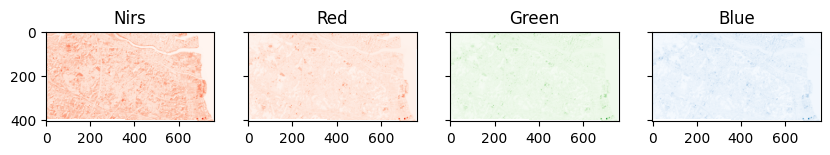

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

# Initialize subplots
fig, (ax1, ax2, ax3, ax4) = plt.subplots(ncols=4, nrows=1, figsize=(10, 4), sharey=True)

# Plot Red, Green and Blue (rgb)
ax1.imshow(nirn, cmap='Reds')
ax2.imshow(redn, cmap='Reds')
ax3.imshow(greenn, cmap='Greens')
ax4.imshow(bluen, cmap='Blues')

# Add titles
ax1.set_title("Nirs")
ax2.set_title("Red")
ax3.set_title("Green")
ax4.set_title("Blue")

In [ ]:
#  reading bands from input
with rio.open(raster_loc) as img:
    bands = (img.read()).shape[0]
print('Bands of input image: ', bands)

# using ilteration to automatically create a bands list

features = []
for i in range(bands):
    features.append('band'+str(i+1))
print('Bands names: ', features)
f_len = len(features)

points = gpd.read_file(points_loc)
# adding a new column 'id' with range of points
points = points.assign(id=range(len(points)))
# saving nenw point file with 'id'
points.to_file(temp_point_loc)
# converting gdf to pd df and removing geometry
points_df = pd.DataFrame(points.drop(columns='geometry'))

# ilterating over multiband raster
sampled = pd.Series()

#inputShape= temp_point_loc
# Read input shapefile with fiona and iterate over each feature
with fiona.open(temp_point_loc) as shp:
    for feature in shp:
        siteID = feature['properties']['id']
        coords = feature['geometry']['coordinates']
        # Read pixel value at the given coordinates using Rasterio
        # NB: `sample()` returns an iterable of ndarrays.
        with rio.open(raster_loc) as stack_src:
                  value = [v for v in stack_src.sample([coords])]
        # Update the pandas serie accordingly
        sampled.loc[siteID] = value

# reshaping sampled values
df1 = pd.DataFrame(sampled.values.tolist(), index=sampled.index)
df1['id'] = df1.index
df1 = pd.DataFrame(df1[0].values.tolist(),
                   columns=features)
df1['id'] = df1.index

data = pd.merge(df1, points_df, on ='id')
print('Sampled Data: \n',data)

x = data.iloc[:,0:f_len]
X = x.values
y = data.iloc[:,-1]
Y = y.values

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.30, stratify = Y)

print(f'X_train Shape: {X_train.shape}\nX_test Shape: {X_test.shape}\ny_train Shape: {y_train.shape}\ny_test Shape:{y_test.shape}')


Bands of input image:  4
Bands names:  ['band1', 'band2', 'band3', 'band4']


<ipython-input-8-babebf8215b6>:23: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  sampled = pd.Series()


Sampled Data: 
       band1   band2   band3   band4   id  labels
0    0.0268  0.0404  0.0228  0.0100    0     1.0
1    0.0284  0.0430  0.0248  0.0111    1     1.0
2    0.0272  0.0402  0.0234  0.0107    2     1.0
3    0.0258  0.0408  0.0231  0.0099    3     1.0
4    0.0248  0.0436  0.0228  0.0107    4     1.0
..      ...     ...     ...     ...  ...     ...
116  0.1066  0.1080  0.1208  0.1368  116     4.0
117  0.1022  0.1092  0.1192  0.1432  117     4.0
118  0.3632  0.3724  0.3644  0.3596  118     4.0
119  0.0849  0.0797  0.0773  0.0918  119     4.0
120  0.0818  0.0902  0.0934  0.1130  120     4.0

[121 rows x 6 columns]
X_train Shape: (84, 4)
X_test Shape: (37, 4)
y_train Shape: (84,)
y_test Shape:(37,)


# Support Vector Machine (SVM)

Accuracy SVM: 100.0
              precision    recall  f1-score   support

         1.0       1.00      1.00      1.00         8
         2.0       1.00      1.00      1.00         8
         3.0       1.00      1.00      1.00         7
         4.0       1.00      1.00      1.00        14

    accuracy                           1.00        37
   macro avg       1.00      1.00      1.00        37
weighted avg       1.00      1.00      1.00        37

Confusion Matrix RF: 
 [[ 8  0  0  0]
 [ 0  8  0  0]
 [ 0  0  7  0]
 [ 0  0  0 14]]


Text(45.74999999999999, 0.5, 'Actual')

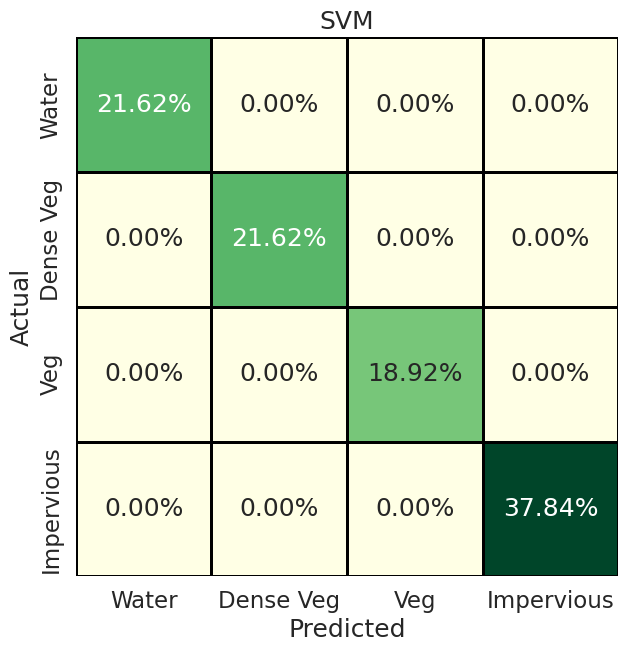

In [ ]:
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
cName = 'SVM'
clf = SVC(kernel='rbf')
clf.fit(X_train, y_train)

clf_pred = clf.predict(X_test)

print(f"Accuracy {cName}: {accuracy_score(y_test, clf_pred)*100}")
print(classification_report(y_test, clf_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, clf_pred)
print('Confusion Matrix RF: \n',cm)
cm_percent = cm/np.sum(cm)

plt.figure(figsize=(7, 7), facecolor='w', edgecolor='k')
sns.set(font_scale=1.5)

sns.heatmap(cm_percent,
            xticklabels=lulc_name,
            yticklabels=lulc_name,
            cmap="YlGn",
            annot=True,
            fmt='.2%',
            cbar=False,
            linewidths=2,
            linecolor='black')

plt.title(cName)
plt.xlabel('Predicted')
plt.ylabel('Actual')
#plt.savefig(f'../figs/confusion_matrix_{cName}.png', dpi=300, bbox_inches='tight')

## full data reshaping, predicting, and saving output

In [ ]:
%%time
cName = 'SVM'
exp_name = f'lulc_{cName}.tif'


img = rio.open(raster_loc)
img_arr = img.read()
bands = img_arr.shape[0]
print(f'Height: {img_arr.shape[1]}\nWidth: {img_arr.shape[2]}\nBands: {img_arr.shape[0]}\n')
img_n = np.moveaxis(img_arr, 0, -1)
img_n = img_n.reshape(-1, f_len)
print('reshaped full data shape  for prediction: ',img_n.shape)
metadata = img.meta
height = metadata.get('height')
width = metadata.get('width')
crs = metadata.get('crs')
transform = metadata.get('transform')


pred_full = clf.predict(img_n)

print('Prediction Done, now exporting raster \n')

img_reshape = pred_full.reshape(height, width)

out_raster = rio.open(exp_name,
                                         'w',
                                          driver='GTiff',
                                          height=height,
                                          width=width,
                                          count=1,
                                          dtype='uint8',
                                          crs=crs,
                                          transform = transform,
                                          nodata = 255 #nodata
                                          )

out_raster.write(img_reshape, 1)
out_raster.close()

print(f'Map saved {cName}.................')

Height: 406
Width: 763
Bands: 4

reshaped full data shape  for prediction:  (309778, 4)
Prediction Done, now exporting raster 

Map saved SVM.................
CPU times: user 882 ms, sys: 24.7 ms, total: 906 ms
Wall time: 902 ms


## Random Forest

Accuracy RF: 97.2972972972973
              precision    recall  f1-score   support

         1.0       1.00      1.00      1.00         8
         2.0       1.00      1.00      1.00         8
         3.0       0.88      1.00      0.93         7
         4.0       1.00      0.93      0.96        14

    accuracy                           0.97        37
   macro avg       0.97      0.98      0.97        37
weighted avg       0.98      0.97      0.97        37

Confusion Matrix RF: 
 [[ 8  0  0  0]
 [ 0  8  0  0]
 [ 0  0  7  0]
 [ 0  0  1 13]]
CPU times: user 283 ms, sys: 16 ms, total: 299 ms
Wall time: 401 ms


Text(45.74999999999999, 0.5, 'Actual')

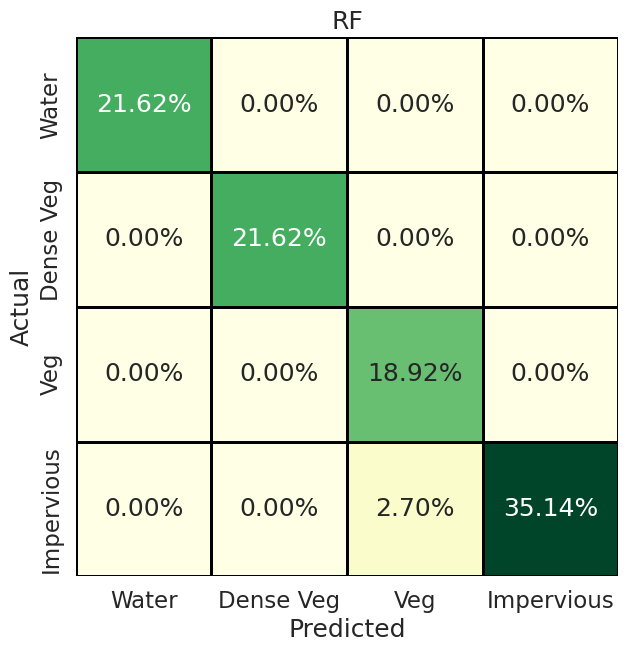

In [ ]:
%%time
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix

cName = 'RF'


clf = RandomForestClassifier(random_state=42)
clf.fit(X_train, y_train)

clf_pred = clf.predict(X_test)

print(f"Accuracy {cName}: {accuracy_score(y_test, clf_pred)*100}")
print(classification_report(y_test, clf_pred))


# Confusion Matrix

cm = confusion_matrix(y_test, clf_pred)
print('Confusion Matrix RF: \n',cm)
cm_percent = cm/np.sum(cm)

plt.figure(figsize=(7, 7), facecolor='w', edgecolor='k')
sns.set(font_scale=1.5)

sns.heatmap(cm_percent,
            xticklabels=lulc_name,
            yticklabels=lulc_name,
            cmap="YlGn",
            annot=True,
            fmt='.2%',
            cbar=False,
            linewidths=2,
            linecolor='black')

plt.title(cName)
plt.xlabel('Predicted')
plt.ylabel('Actual')
#plt.savefig(f'../figs/confusion_matrix_{cName}.png', dpi=300, bbox_inches='tight')

## full data reshaping, predicting, and saving output

In [ ]:
%%time

cName = 'RF'
exp_name = f'lulc_{cName}.tif'


img = rio.open(raster_loc)
img_arr = img.read()
bands = img_arr.shape[0]
print(f'Height: {img_arr.shape[1]}\nWidth: {img_arr.shape[2]}\nBands: {img_arr.shape[0]}\n')
img_n = np.moveaxis(img_arr, 0, -1)
img_n = img_n.reshape(-1, f_len)
print('reshaped full data shape  for prediction: ',img_n.shape)


pred_full = clf.predict(img_n)

print('Prediction Done, now exporting raster \n')
# Predefining out raster meta using variable raster
tempfile_arr = img.read(1)
tempfile_arr = tempfile_arr.reshape(-1,1)
metadata = img.meta

height = metadata.get('height')
width = metadata.get('width')
crs = metadata.get('crs')
transform = metadata.get('transform')

img_reshape = pred_full.reshape(height, width)

out_raster = rio.open(exp_name,
                                         'w',
                                          driver='GTiff',
                                          height=height,
                                          width=width,
                                          count=1,
                                          dtype='uint8',
                                          crs=crs,
                                          transform = transform,
                                          nodata = 255 #nodata
                                          )

out_raster.write(img_reshape, 1)
out_raster.close()

print(f'Map saved {cName}.................')

Height: 406
Width: 763
Bands: 4

reshaped full data shape  for prediction:  (309778, 4)
Prediction Done, now exporting raster 

Map saved RF.................
CPU times: user 2.01 s, sys: 20.6 ms, total: 2.03 s
Wall time: 2.02 s


## Decision Tree

Accuracy DT: 97.2972972972973
              precision    recall  f1-score   support

         1.0       1.00      1.00      1.00         8
         2.0       1.00      1.00      1.00         8
         3.0       1.00      0.86      0.92         7
         4.0       0.93      1.00      0.97        14

    accuracy                           0.97        37
   macro avg       0.98      0.96      0.97        37
weighted avg       0.97      0.97      0.97        37

Confusion Matrix RF: 
 [[ 8  0  0  0]
 [ 0  8  0  0]
 [ 0  0  6  1]
 [ 0  0  0 14]]
CPU times: user 110 ms, sys: 1.7 ms, total: 111 ms
Wall time: 126 ms


Text(45.74999999999999, 0.5, 'Actual')

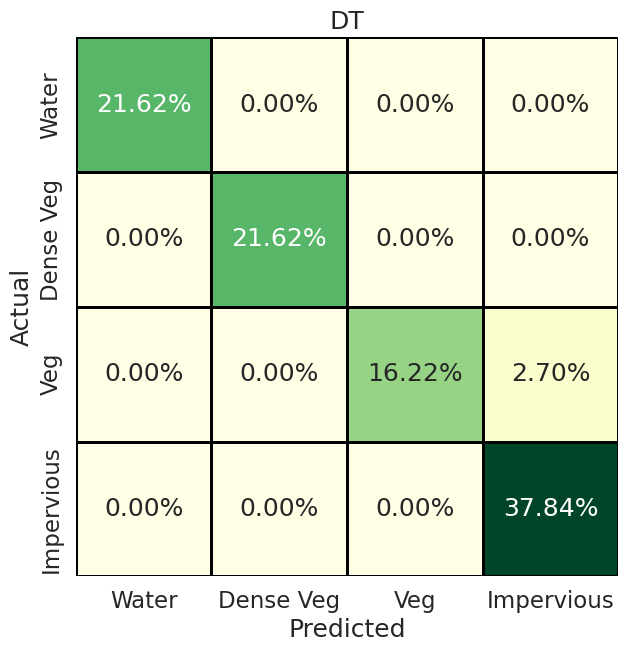

In [ ]:
%%time
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix

cName = 'DT'

clf = DecisionTreeClassifier(random_state=42)
clf.fit(X_train, y_train)

clf_pred = clf.predict(X_test)

print(f"Accuracy {cName}: {accuracy_score(y_test, clf_pred)*100}")
print(classification_report(y_test, clf_pred))


# Confusion Matrix

cm = confusion_matrix(y_test, clf_pred)
print('Confusion Matrix RF: \n',cm)
cm_percent = cm/np.sum(cm)

plt.figure(figsize=(7, 7), facecolor='w', edgecolor='k')
sns.set(font_scale=1.5)

sns.heatmap(cm_percent,
            xticklabels=lulc_name,
            yticklabels=lulc_name,
            cmap="YlGn",
            annot=True,
            fmt='.2%',
            cbar=False,
            linewidths=2,
            linecolor='black')

plt.title(cName)
plt.xlabel('Predicted')
plt.ylabel('Actual')
#plt.savefig(f'../figs/confusion_matrix_{cName}.png', dpi=300, bbox_inches='tight')

In [ ]:
%%time

cName = 'DT'
exp_name = f'lulc_{cName}.tif'


img = rio.open(raster_loc)
img_arr = img.read()
bands = img_arr.shape[0]
print(f'Height: {img_arr.shape[1]}\nWidth: {img_arr.shape[2]}\nBands: {img_arr.shape[0]}\n')
img_n = np.moveaxis(img_arr, 0, -1)
img_n = img_n.reshape(-1, f_len)
print('reshaped full data shape  for prediction: ',img_n.shape)


pred_full = clf.predict(img_n)

print('Prediction Done, now exporting raster \n')
# Predefining out raster meta using variable raster
tempfile_arr = img.read(1)
tempfile_arr = tempfile_arr.reshape(-1,1)
metadata = img.meta

height = metadata.get('height')
width = metadata.get('width')
crs = metadata.get('crs')
transform = metadata.get('transform')

img_reshape = pred_full.reshape(height, width)

out_raster = rio.open(exp_name,
                                         'w',
                                          driver='GTiff',
                                          height=height,
                                          width=width,
                                          count=1,
                                          dtype='uint8',
                                          crs=crs,
                                          transform = transform,
                                          nodata = 255 #nodata
                                          )

out_raster.write(img_reshape, 1)
out_raster.close()

print(f'Map saved {cName}.................')

Height: 406
Width: 763
Bands: 4

reshaped full data shape  for prediction:  (309778, 4)
Prediction Done, now exporting raster 

Map saved DT.................
CPU times: user 124 ms, sys: 3.87 ms, total: 128 ms
Wall time: 237 ms


In [ ]:
# Importing required libraries
import rasterio as rio
import geopandas as gpd
import fiona
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

# Provide the path to the data
raster_loc = 'materials/rasters/s2image.tif'
points_loc = 'materials/shapefiles/samples.shp'
temp_point_loc = 'materials/temp/temp_y_points.shp'

# Load raster data and visualize
src = rio.open(raster_loc)
bands_data = [src.read(i, masked=True) for i in range(1, src.count + 1)]

# Normalize the bands
normalized_bands = [(band - band.min()) / (band.max() - band.min()) for band in bands_data]

# Visualize RGB and False Color Composite
rgb = np.dstack(normalized_bands[2::-1])  # RGB
nrg = np.dstack([normalized_bands[3], normalized_bands[2], normalized_bands[1]])  # False Color Composite

plt.imshow(rgb)
plt.title('RGB Visualization')
plt.show()

plt.imshow(nrg)
plt.title('False Color Composite Visualization')
plt.show()

# Visualize each band separately
fig, axs = plt.subplots(1, src.count, figsize=(15, 3), sharey=True)
for i, ax in enumerate(axs):
    ax.imshow(normalized_bands[i], cmap='viridis')
    ax.set_title(f'Band {i + 1}')

# Feature extraction
with rio.open(raster_loc) as img:
    bands = img.count

features = [f'band{i}' for i in range(1, bands + 1)]

points = gpd.read_file(points_loc)
points['id'] = range(len(points))

# Save the points with IDs
temp_point_loc = 'materials/temp/temp_y_points.shp'
points.to_file(temp_point_loc)

# Iterating over multiband raster to sample data
sampled_data = pd.DataFrame()

with fiona.open(temp_point_loc) as shp:
    for feature in shp:
        site_id = feature['properties']['id']
        coords = feature['geometry']['coordinates']

        with rio.open(raster_loc) as stack_src:
            pixel_values = [v for v in stack_src.sample([coords])]

        sampled_data.loc[site_id, features] = pixel_values

# Merging sampled values with point data
data = pd.merge(sampled_data, points.drop(columns='geometry'), left_index=True, right_on='id')

# Splitting data into features (X) and labels (Y)
X = data[features].values
Y = data['labels'].values

# Splitting data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.30, stratify=Y)

# Support Vector Machine (SVM) model
clf_svm = SVC(kernel='rbf')
clf_svm.fit(X_train, y_train)

# Predictions and evaluation for SVM
svm_pred = clf_svm.predict(X_test)
print("Support Vector Machine (SVM) Results:")
print(f"Accuracy: {accuracy_score(y_test, svm_pred) * 100}")
print(classification_report(y_test, svm_pred))

# Random Forest (RF) model
clf_rf = RandomForestClassifier(random_state=42)
clf_rf.fit(X_train, y_train)

# Predictions and evaluation for RF
rf_pred = clf_rf.predict(X_test)
print("\nRandom Forest (RF) Results:")
print(f"Accuracy: {accuracy_score(y_test, rf_pred) * 100}")
print(classification_report(y_test, rf_pred))

# Decision Tree (DT) model
clf_dt = DecisionTreeClassifier(random_state=42)
clf_dt.fit(X_train, y_train)

# Predictions and evaluation for DT
dt_pred = clf_dt.predict(X_test)
print("\nDecision Tree (DT) Results:")
print(f"Accuracy: {accuracy_score(y_test, dt_pred) * 100}")
print(classification_report(y_test, dt_pred))

# Full data reshaping, predicting, and saving output for SVM
exp_name_svm = 'materials/results/lulc_SVM.tif'
full_data_svm_pred = clf_svm.predict(X.reshape(-1, bands))
full_data_svm_reshape = full_data_svm_pred.reshape(src.height, src.width)

# ... (similar process for saving SVM results)

# Full data reshaping, predicting, and saving output for RF
exp_name_rf = 'materials/results/lulc_RF.tif'
full_data_rf_pred = clf_rf.predict(X.reshape(-1, bands))
full_data_rf_reshape = full_data_rf_pred.reshape(src.height, src.width)

# ... (similar process for saving RF results)

# Full data reshaping, predicting, and saving output for DT
exp_name_dt = 'materials/results/lulc_DT.tif'
full_data_dt_pred = clf_dt.predict(X.reshape(-1, bands))
full_data_dt_reshape = full_data_dt_pred.reshape(src.height, src.width)

# ... (similar process for saving DT results)
